# Présentation générale du projet

L'idée initiale de ce projet était d'étudier le lien entre l'orientation politique et des variables "originales". Nous voulions voir s'il y avait un lien, et si oui, dans quelle mesure ce lien était-il fort.

Nous avions donc en premier lieu choisi d'analyser le caractère "fleuri" de certaines villes. Après avoir fait des tentatives de scrapping de ce site et en avoir discuté avec notre chargé de td, nous avons estimé que récupérer les données dont nous avions besoin serait trop coûteux en terme de temps et d'énergie et nous avons abandonné cette première option.

Nous nous sommes donc rabattues sur les tables de l'INSEE, qui étaient téléchargeables ou disponibles avec des liens API. Le catalogue de l'INSEE proposait de nombreuses bases intéressantes mais les thèmes que nous aurions pu aborder (toujours en lien avec la politique). Nous nous étions tout d'abord orientées vers des bases nous permettant d'avoir d'étudier des variables lourdes assez "classiques" (sexe, âge, revenu). Cependant, nous n'avions accès à des résultats électoraux qu'au niveau de la commune (pour le niveau le plus fin qu'il était possible de jointer avec les bases de l'INSEE), et nous avions donc peur que les données aient une variance trop faible pour avoir des résultats intéressants (notamment l'âge ou le sexe). 

C'est ainsi que nous avons décidé d'utiliser la base regroupant toutes les infrastructures présentes en France. Cette base est intéressante car très fournie, et parce qu'elle permet d'étudier caractéristiques des communes, telles que leur proximité à la culture, ou la présence de services publics qu'il peut y avoir.

D'un autre côté, nous devions trouver la base de données qui nous permettrait d'étudier l'orientation politique des communes. Nous avons alors été confrontées à plusieurs difficultés dans le choix de la base et dans l'évaluation de leur orientation politique :
- un choix naturel aurait été d'étudier les élections municipales car notre population étudiée était les communes françaises ; mais les élections municipales présentaient trop de candidats sans étiquette alors impossibles à placer sur l'axe gauche droite, de même, pour les élections législatives, les partis ne présentaient pas des candidats dans toutes les circonscriptions, ce qui posait problème pour notre analyse -> finalement nous avons choisi la base des élections présidentielles de 2017 ;
- l'autre problème a été l'évaluation du bord politique du parti. Plusieurs options s'offraient à nous : placer chaque parti sur un axe gradué gauche-droite et faire une moyenne (quelle moyenne ?) ou s'intéresser à certains partis, mais alors lesquels ? Finalement, nous avons choisi la deuxième option, et nous sommes intéressées aux partis LFI et RN, et donc, dans le contexte de l'élection présidentielle de 2022, aux résultats respectifs de M. Mélenchon et Mme Le Pen. 

En résumé, notre objectif a été d'étudier les liens entre les infrastructures présentes dans la ville (et à travers cela, l'accès aux infrastructures de loisir, de santé ou de services publiques) et le vote pour les partis LFI et RN lors des élections présidentielles de 2022.

> [site internet du label villes et villages fleuris](https://villes-et-villages-fleuris.com/)

> [documentation](https://github.com/heloise1414/Projet-Python-S3/blob/main/code/documentation.ipynb)



# Récupération des données et nettoyage

Dans cette première partie, nous allons récupérer les données et les nettoyer. Cette partie nécessite l'installation du module openpyxl afin de bien fonctionner. Nous allons détailler la récupération dde chaque base ainsi que les sources dans la partie dédiée.

# 0. Préparation de l'environnement de travail

Pour le bon déroulé du projet, on installe ou importe les packages suivants : 
- openpyxl : pour la récupération des données
- requests : pour la récupération des données par API
- pyarrow : pour passer du format csv au format parquet
- pandas : pour la création et la manipulation de tableaux de données
- geopandas : pour la gestion des données spatiales
- matplotlib.pyplot : pour tracer des figures
- numpy : pour les outils mathématiques

In [1]:
!pip install openpyxl 
!pip install pyarrow

import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


# 1. Importation des données

Les sources que nous avons utilisées proposaient toutes des liens pour les requêtes API, mais nous avons préféré diversifier les manières de télécharger les bases afin de s'approprier les différentes méthodes. Nous avons donc utilisé une API pour la base de donnée sur les élections car le site proposait une API stable, et nous avons téléchargé la base des infrastructures.

## a. Elections présidentielles

Le choix de la base à étudier pour évaluer l'orientation politique des communes a été compliqué. Nous n'avions pas de souci de récupération des bases car tout était disponible sur le [site data.gouv](https://www.data.gouv.fr/datasets/search), en revanche, nous avions presque trop d'options.

Ainsi, nous avons hésité entre trois bases :
- [élections municipales 2020](https://www.data.gouv.fr/datasets/elections-municipales-2020-resultats-1er-tour) : l'avantage de cette base était le fait d'étudier des élus locaux pour une population locale (les communes), les limites étaient le grand nombre de candidats sans étiquette, particulièrement dans les petites communes, la date des dernières élections (un peu anciennes), et le taux élevé d'abstention ;
- [élections législatives 2024](https://www.data.gouv.fr/datasets/elections-legislatives-des-30-juin-et-7-juillet-2024-resultats-definitifs-du-1er-tour) : l'avantage de cette base était la date de ces élections, qui correspondait à celle de notre base sur les infrastructures, les limites était la volatilité des candidats. Tous les partis ne présentaient pas des candidats dans toutes les circonscriptions, généralement ils présentent un candidat dans les circonscriptions qu'ils estiment pouvoir gagner. Ainsi, nous risquions d'avoir une corrélation complètement surévaluée ;
- [élection présidentielle 2022](https://www.data.gouv.fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour) : finalement, nous avons opté pour l'élection présidentielle de 2022. Les candidats étaient les mêmes pour tous les bureaux de vote ce qui nous simplifiait largement le travail. Les limites de cette base sont toutefois nombreuses, nous y reviendrons au fur et à mesure de notre étude, mais nous avons a priori repéré deux grands problèmes liés à la conjoncture politique et à la nature de l'élection : d'une part, on peut craindre un "effet candidat" (autrement dit, l'élection présidentielle nous permet de mesurer l'adhésion à un candidat et non à un parti), par ailleurs un "effet conjoncture" dû aux élections précédentes (et au second tour avec M. Macron et Mme Le Pen) qui pourrait influencer les comportements des électeurs.

Le choix d'étudier le premier tour de l'élection nous a paru assez naturel car il permettait d'éviter d'avoir un duel et un vote barrage. Malheureusement, le niveau communal n'est pas proposé, donc nous avons choisi de télécharger le niveau **sous-communal** dans l'optique d'agréger les résultats par la suite. 

In [2]:
url_elect = "https://www.data.gouv.fr/api/1/datasets/r/6d9b33e5-667d-4c3e-9a0b-5fdf5baac708"
path_elect = "/home/onyxia/work/Projet-Python-S3/code/results_elect.xlsx"

# Téléchargement du fichier Excel
response = requests.get(url_elect)
response.raise_for_status()

with open(path_elect, "wb") as f:
    f.write(response.content)

# Lecture du fichier Excel
df_extrait = pd.read_excel(path_elect, sheet_name=0)

print("Le dataframe df_extrait peut être traité comme un data frame classique avec pandas")

print("Informations sur le dataframe df_extrait qui est notre df initial")
print(df_extrait.columns)
print(len(df_extrait))


# la colonne unamed 53 correspond au nombre de voix de JLF, la colonne unamed 67 correspond à celui de marine le pen
liste_var = ['Code du département', 
    'Libellé du département', 
    'Code de la commune', 
    'Libellé de la commune',
    'Inscrits', 
    'Abstentions',
    'Exprimés',
    '% Abs/Ins',
    'Unnamed: 51',
    'Unnamed: 53', 
    'Unnamed: 65',
    'Unnamed: 67']
df_elect = df_extrait[liste_var]
df_elect = df_elect.rename(columns={'Unnamed: 51': 'voix_rn'})
df_elect = df_elect.rename(columns={'Unnamed: 53': 'score_rn'})
df_elect = df_elect.rename(columns={'Unnamed: 65': 'voix_lfi'})
df_elect = df_elect.rename(columns={'Unnamed: 67': 'score_lfi'})
print(df_elect.head(3))

Le dataframe df_extrait peut être traité comme un data frame classique avec pandas
Informations sur le dataframe df_extrait qui est notre df initial
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Unnamed: 93', 'Unnamed: 94', 'Unnamed: 95', 'Unnamed: 96',
       'Unnamed: 97', 'Unnamed: 98', 'Unnamed: 99', 'Unnamed: 100',
       'Unnamed: 101', 'Unnamed: 102'],
      dtype='object', length=103)
35245
  Code du département Libellé du département  Code de la commune  \
0                  01                    Ain                   1   
1                  01                    Ain                   2   
2                  01                    Ain                   4   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
0  L'Abergement-Clémenciat       645          108       520      16.74   
1    L'A

Ici, en observant les premières lignes du df, on remarque que certaines villes ont pour code de la commune "1" au lieu de "001". Nous allons donc mettre en forme le df pour que la table soit plus lisible et que la clé externe qui permettra de faire la jointure avec la base des infrastructures fonctionne.

In [3]:
df_elect["Code de la commune"] = df_elect["Code de la commune"].astype(str)
df_elect["Code du département"] = df_elect["Code du département"].astype(str)

On commence par mettre toutes les colonnes au format str.

In [4]:
# la fonction zfill permet de remplir la chaîne de caractères à gauche afin qu'elle ait le bon format (3 caractères)
df_elect["Code de la commune"] = df_elect["Code de la commune"].str.zfill(3)
df_elect["code_insee"] = df_elect["Code du département"] + df_elect["Code de la commune"]
print(df_elect.head(4))

  Code du département Libellé du département Code de la commune  \
0                  01                    Ain                001   
1                  01                    Ain                002   
2                  01                    Ain                004   
3                  01                    Ain                005   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
0  L'Abergement-Clémenciat       645          108       520      16.74   
1    L'Abergement-de-Varey       213           38       171      17.84   
2        Ambérieu-en-Bugey      8765         2078      6553      23.71   
3      Ambérieux-en-Dombes      1282          234      1028      18.25   

   voix_rn  score_rn  voix_lfi  score_lfi code_insee  
0      149     28.65        66      12.69      01001  
1       23     13.45        41      23.98      01002  
2     1646     25.12      1604      24.48      01004  
3      352     34.24       137      13.33      01005  


Ensuite, on s'occupe de créer une colonne code_insee qui a le bon format.

## b. Infrastructures sportives et culturelles

> Nous avons choisi le téléchargement car une mise à jour était annoncée pour le 1er janvier 2027 sur le site de l'INSEE (nous ne pouvions donc pas utiliser de requête API).

Cette base de données recense les équipements par type d'équipement et par niveau géographique au 1er janvier de l'année 2024. Les domaines présents dans la table sont les suivants : services pour les particuliers, commerces, enseignement, santé et action sociale, transports et déplacements, sports, loisirs et culture, tourisme. Cela nous permet donc d'étudier des formes d'intégration diverses (intégration administrative, culturelle, économique, etc). 

### i. Métadonnées

Dans un premier temps, on récupère les métadonnées de la base, qui regroupe les libellés de toutes les modalités prises par les variables. Cela nous permettra d'avoir des résultats plus lisibles et compréhensibles.

In [10]:
path_infrastructures_meta_s3 = "s3://clemencelucas/projet_python_vote_rn/data/raw/DS_BPE_SPORT_CULTURE_2024_metadata.csv"
df_infrastructures_meta = pd.read_csv(path_infrastructures_meta_s3, sep=';') 

df_infrastructures_meta.head(20)

,COD_VAR,LIB_VAR,COD_MOD,LIB_MOD
0,BPE_MEASURE,Mesure BPE,FACILITIES,Nombre d'équipements
1,BPE_MEASURE,Mesure BPE,PLAYGROUNDS,Nombre d'aires de pratiques sportives d'un mêm...
2,BPE_MEASURE,Mesure BPE,ROOMS,Nombre de salles de cinéma ou théâtre
3,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,1,Au-dessus de 1500 personnes
4,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,3,De 301 à 700 Personnes
5,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,2,De 701 à 1500 personnes
6,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,4,De 101 à 300 personnes
7,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,5,Inférieur ou égal à 100 personnes
8,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,_U,Indéterminé
9,ERP_CATEGORY,Catégorie d’établissement recevant du public (...,_Z,Sans objet


In [11]:
df_infrastructures_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35722 entries, 0 to 35721
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   COD_VAR  35722 non-null  object
 1   LIB_VAR  35722 non-null  object
 2   COD_MOD  35722 non-null  object
 3   LIB_MOD  35722 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


D'une part, on n'a pas de valeurs nulles à proprement parler. On ne sait pas encore s'il n'y a vraiment pas de valeurs manquantes où si elles sont codées autrement, on le vérifiera par la suite. D'autre part panda considère les 4 colonnes du fichier des métadonnées comme étant de type *object*, alors qu'elles sont toutes de type *string*. On les modifie donc, de la même manière en créant une copie du fichier qu'on modifie. 

In [12]:
df_infrastructures_meta_typed = df_infrastructures_meta.copy() #on fait une copie pour garder quelque part les données originales
df_infrastructures_meta_typed["COD_VAR"] = df_infrastructures_meta_typed["COD_VAR"].astype(str)
df_infrastructures_meta_typed["LIB_VAR"] = df_infrastructures_meta_typed["LIB_VAR"].astype(str)
df_infrastructures_meta_typed["COD_MOD"] = df_infrastructures_meta_typed["COD_MOD"].astype(str)
df_infrastructures_meta_typed["LIB_MOD"] = df_infrastructures_meta_typed["LIB_MOD"].astype(str)

### ii. Données

Dans un premier temps, on récupère les données relatives aux infrastructures sportives et culturelles en France. L'Insee (sur **[insee.fr](https://catalogue-donnees.insee.fr/fr/catalogue/recherche/DS_BPE_SPORT_CULTURE)**) propose une base d'équipements et de service accessibles à la population au niveau communal, intercommunal, départemental, régional... 

> Nous nous intéresserons au **niveau communal**, dans l'optique de faire de même pour les résultats aux élections présidentielles. 

Ce jeu de données est valide pour le **1er janvier 2024**, moins de deux ans après les élections présidentielles. L'écart de temps est donc faible étant donné le temps de construction et la durée de vie en général des infrastructures étudiées, d'où la pertinence de cette base de données. 

<span style="color:red">Le fichier csv téléchargé a été stocké sur notre espace S3 personnel, il faudra probablement changer le chemin d'accès pour y accéder. </span>

In [13]:
path_infrastructures_s3 = "s3://clemencelucas/projet_python_vote_rn/data/raw/DS_BPE_SPORT_CULTURE_2024_data.csv"
df_infrastructures = pd.read_csv(path_infrastructures_s3, sep=';') 

df_infrastructures.head()

/tmp/ipykernel_193677/1717241771.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_infrastructures = pd.read_csv(path_infrastructures_s3, sep=';')


,GEO,GEO_OBJECT,FACILITY_DOM,FACILITY_SDOM,FACILITY_TYPE,INDOOR,LIGHTED,PRACTICE_AREA_ACCESSIBILITY,SANITARY_ACCESSIBILITY,LOCKER_ROOM_ACCESSIBILITY,FREE_ACCESS,SHOWER,SANITARY,SEASONAL_OPENING,MULTIPLEX_CINEMA,ERP_CATEGORY,BPE_MEASURE,TIME_PERIOD,OBS_VALUE
0,69,DEP,F,F1,F101,1,1,0,0,_U,_U,_U,1,0,_Z,2,FACILITIES,2024,1
1,12,DEP,F,F1,F101,0,0,0,0,1,_U,_U,1,1,_Z,3,FACILITIES,2024,1
2,59,DEP,F,F1,F101,1,1,0,0,0,0,1,1,0,_Z,1,FACILITIES,2024,1
3,18,DEP,F,F1,F101,1,1,1,0,0,0,1,1,1,_Z,3,FACILITIES,2024,1
4,45,DEP,F,F1,F101,1,1,1,1,1,_U,_U,1,0,_Z,3,FACILITIES,2024,1


In [14]:
df_infrastructures.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351761 entries, 0 to 1351760
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype 
---  ------                       --------------    ----- 
 0   GEO                          1351761 non-null  object
 1   GEO_OBJECT                   1351761 non-null  object
 2   FACILITY_DOM                 1351761 non-null  object
 3   FACILITY_SDOM                1351761 non-null  object
 4   FACILITY_TYPE                1351761 non-null  object
 5   INDOOR                       1351761 non-null  object
 6   LIGHTED                      1351761 non-null  object
 7   PRACTICE_AREA_ACCESSIBILITY  1351761 non-null  object
 8   SANITARY_ACCESSIBILITY       1351761 non-null  object
 9   LOCKER_ROOM_ACCESSIBILITY    1351761 non-null  object
 10  FREE_ACCESS                  1351761 non-null  object
 11  SHOWER                       1351761 non-null  object
 12  SANITARY                     1351761 non-null  object
 1

On remarque en premier lieu qu'il n'y a pas de cases vides car, pour chaque colonne, on a 1 351 761 non-null correspondant à l'entièreté des lignes.  

> **Remarque** : Aucune case n'est vide, mais certaines comportent un code signifiant "Indéterminé" (_U) ou "Sans objet" (_Z). On s'intéressera au problème des valeurs manquantes par la suite.

On observe également que panda interprète la quasi totalité des colonnes comme des types *object* donc on lui indique quels sont les types des colonnes qui nous intéressent. 
- GEO : elle comporte un code, une clé qui permet d'identifier une zone géographique. On pourrait penser qu'il s'agit forcément d'un entier, mais les départements Corses sont 2A et 2B et comportent une lettre, et il arrive que des communes aient un code commençant par 0. Il vaut donc mieux considérer cette colonne comme étant de type *string*
- GEO_OBJECT : elle indique le niveau géographique de la ligne (COM pour commune par exemple). Elle est de type *string*. 
- FACILITY_DOM, FACILITY_SDOM, FACILITY_TYPE : elles indiquent la classification des types d'équipements à différents niveaux (catégories, sous-catégories et types). Ce sont des codes de types *string*. 
- OBS_VALUE : elle indique le nombre d'équipement décrit dans la ligne par les colonnes précédentes présents dans la zone géographique. Elle est de type *int*, mais panda l'a déjà repéré donc pas besoin de faire de modifications. 

Les autres colonnes concernent un degré de précision quant aux équipements que nous considérons trop élevé pour être pertinent (s'il existe une zone illuminée par exemple avec la variable LIGHTED), donc nous les laissons de côté. 

> **Remarque** TIME_PERIOD indique la période d'observation, lors de l'enquête. En l'occurrence, dans ce jeu de données, cette variable est inutile puisqu'elle contient une unique modalité : 2024. De même, FACILITY_DOM ne prend qu'une valeur : F, qui signifie "Sports, loisirs et cultures".

La variable BPE_MEASURE n'a que trois modalités et clarifie le nombre noté dans OBS_VALUE, s'il s'agit d'un nombre d'équipement, un nombre d'aires ou un nombre de salles. Pour simplifier, nous considérerons par la suite que deux aires/deux salles/etc distincts correspondent à deux équipements différents, et nous laissons cette variable de côté. 

In [15]:
#vérification que TIME_PERIOD n'a qu'une valeur 
df_infrastructures["TIME_PERIOD"].value_counts()

TIME_PERIOD
2024    1351761
Name: count, dtype: int64

In [17]:
#vérification que FACILITY_DOM n'a qu'une valeur
df_infrastructures["FACILITY_DOM"].value_counts()

FACILITY_DOM
F    1351761
Name: count, dtype: int64

In [18]:
#vérification des modalités de BPE_MEASURE
modalites_bpe_measure = (
    df_infrastructures["BPE_MEASURE"]
    .unique()
    .tolist()
)

libelles_bpe_measure = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "BPE_MEASURE") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_bpe_measure)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .sort_values("COD_MOD")
)

libelles_bpe_measure

,COD_MOD,LIB_MOD
0,FACILITIES,Nombre d'équipements
1,PLAYGROUNDS,Nombre d'aires de pratiques sportives d'un mêm...
2,ROOMS,Nombre de salles de cinéma ou théâtre


In [19]:
cols_kept = [
    "GEO", "GEO_OBJECT",
    "FACILITY_SDOM", "FACILITY_TYPE", 
    "OBS_VALUE"
]

df_infrastructures_typed = df_infrastructures[cols_kept].copy() #on fait une copie pour garder quelque part les données originales
df_infrastructures_typed["GEO"] = df_infrastructures_typed["GEO"].astype(str)
df_infrastructures_typed["GEO_OBJECT"] = df_infrastructures_typed["GEO_OBJECT"].astype(str)
df_infrastructures_typed["FACILITY_SDOM"] = df_infrastructures_typed["FACILITY_SDOM"].astype(str)
df_infrastructures_typed["FACILITY_TYPE"] = df_infrastructures_typed["FACILITY_TYPE"].astype(str)

Etant donné la taille considérable du fichier (DS_BPE_SPORT_CULTURE_2024_data.csv), il vaut mieux le transformer au format Parquet pour éviter des temps d'exécution trop élevés. 

In [22]:
df_infrastructures_typed.to_parquet(
    "s3://clemencelucas/projet_python_vote_rn/data/intermediate/bpe_parquet_v1",
    engine = "pyarrow",
    index = False, 
    partition_cols = 'GEO_OBJECT'
)

df_infrastructures_typed.head(10)

,GEO,GEO_OBJECT,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,69,DEP,F1,F101,1
1,12,DEP,F1,F101,1
2,59,DEP,F1,F101,1
3,18,DEP,F1,F101,1
4,45,DEP,F1,F101,1
5,86,DEP,F1,F101,2
6,74,DEP,F1,F101,1
7,89,DEP,F1,F101,1
8,27,DEP,F1,F101,1
9,57,DEP,F1,F101,1


## c. Données géographiques

### i. Communes

Pour représenter géographiquement nos résultats, on aura besoin du tracé des communes de France. On récupère les données spatiales issus de l'[IGN](https://geoservices.ign.fr/telechargement-api/ADMIN-EXPRESS-COG?page=0). Nous avons pris le dossier ADMIN-EXPRESS-COG_3-1__SHP_LAMB93_FXX_2022-04-15 pour avoir les tracés des communes correspondant aux élections présidentielles. Pour celle qui ne sont pas présentes dans les données d'infrastructures, on indiquera automatiquement 0. 

<span style='color:red'> **JUSTIFIER MIEUX POURQUOI 2022 ET PAS 2024** </span>

In [26]:
com_geo_path = "s3://clemencelucas/projet_python_vote_rn/data/raw/ADMIN_EXPRESS_COG_communes/COMMUNE.shp"

gdf_com = gpd.read_file(com_geo_path)

gdf_com.head()

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873..."
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5..."
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6..."
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6..."
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597..."


Pour garantir l'homogénéité des codes COG pour la commune, on fait en sorte de garantir que la colonne INSEE_COM ne contienne que des chaines de caractères de taille 5, en rajoutant des 0 si nécessaire. 

In [27]:
gdf_com["INSEE_COM"] = (
    gdf_com["INSEE_COM"]
    .astype(str)
    .str.zfill(5)
)

On vérifie qu'on a bien toutes les valeurs. 

In [28]:
len(gdf_com["INSEE_COM"].unique())

34826

<span style='color:red'> **CHERCHER LE NOMBRE DE COMMUNES FINAL** </span>

# 2. Nettoyage des données

## a. Elections présidentielles

### i. Nombre de communes

Pour préparer cette base à nos travaux, nous avons besoin de faire plusieurs vérifications :
- vérifier que nous avons le bon nombre de communes ;
- vérifier que les résultats sont cohérents avec les résultats nationaux de l'élection de 2022 ;

Par ailleurs, les statisticiens ayant déjà utilisé cette base de données ont fait quelques remarques dans l'onglet [discussions](https://www.data.gouv.fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/discussions) du site :

> *[...] je travaille actuellement sur une application qui récupère les résultats des élections et je remarque que pour les élections présidentielles, il semble y manquer les résultats des bureaux de votes du centre de Paris : plus précisément, il manque le 2e, 3e et le 4e arrondissement. Il manque aussi le bureau 72 du 13e, le bureau 58 du 14e, le bureau 6 du 11e et enfin les bureaux 68 et 69 du 17e.[...]*

> *[...] En regardant les résultats par bureau de vote, j'ai trouvé un bureau manquant (numéro 0602 à Lille, code INSEE 59350). Le bureau de vote est bien existant sur le site open data de la métropole de Lille [...]. Et ce bureau ne semble pas faire partie des bureaux annulés par le conseil constitutionnel.*

>*[...] En effet, en comparant le nombre d'inscrits par bureau de vote entre les deux tours, je trouve 25,209 bureaux de vote où le nombre varie (dont 27 où la variation absolue est supérieure à 50 avec un maximum de 8,345 inscrits de différence pour la 3ème circonscription des français de l'étranger). Le site du conseil constitutionnel suggère que cela pourrait être lié à des demandes d'inscriptions dans l'entre-deux-tours liées à des radiations injustifiées des listes électorales [...]. Cependant, alors qu'en 2022 nous avons plus d'inscrits au second tour, en 2017 nous avons moins d'inscrits au premier tour.[...]*

In [5]:
print("Informations sur le dataframe df_elect")
print("Colonnes")
print(df_elect.columns)
print("Nombre de lignes")
print(len(df_elect))
print("Nombre de communes différentes présentes dans la base")
print(df_elect[['Code du département', 'Code de la commune']].drop_duplicates().shape[0]) 
    # on doit utiliser les deux variables car le code commune n'est unique qu'au sein du département
print("Vérification des doublons")
print(df_elect[df_elect.duplicated(subset=['Code du département', 'Code de la commune'],keep=False)])

Informations sur le dataframe df_elect
Colonnes
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Inscrits', 'Abstentions', 'Exprimés',
       '% Abs/Ins', 'voix_rn', 'score_rn', 'voix_lfi', 'score_lfi',
       'code_insee'],
      dtype='object')
Nombre de lignes
35245
Nombre de communes différentes présentes dans la base
35245
Vérification des doublons
Empty DataFrame
Columns: [Code du département, Libellé du département, Code de la commune, Libellé de la commune, Inscrits, Abstentions, Exprimés, % Abs/Ins, voix_rn, score_rn, voix_lfi, score_lfi, code_insee]
Index: []


Cette sortie python nous permet de savoir plusieurs choses sur la base de données :
- nous avons **35245** communes dans la table, ce qui correspond au nombre de lignes de la table, en revanche, il y avait **[34955 communes](https://fr.wikipedia.org/wiki/Nombre_de_communes_en_France#Ann%C3%A9e_2022)** en France en 2022, nous allons donc devoir approfondir ce point ;
- il n'y a **pas de ville en doublon** dans la table (*Vérification des doublons, Empty DataFrame*)


In [6]:
print("Nombre de communes différentes présentes dans la base")
print(df_elect[['Libellé de la commune']].drop_duplicates().shape[0]) 
    # on doit utiliser les deux variables car le code commune n'est unique qu'au sein du département
print("Vérification des doublons")
print(df_elect[df_elect.duplicated(subset=['Libellé de la commune'],keep=False)])

Nombre de communes différentes présentes dans la base
32988
Vérification des doublons
      Code du département           Libellé du département Code de la commune  \
9                      01                              Ain                011   
23                     01                              Ain                027   
26                     01                              Ain                030   
35                     01                              Ain                039   
38                     01                              Ain                042   
...                   ...                              ...                ...   
35133                  ZZ  Français établis hors de France                109   
35134                  ZZ  Français établis hors de France                110   
35135                  ZZ  Français établis hors de France                111   
35181                  ZZ  Français établis hors de France                160   
35232                  

Cette sortie nous donne une piste pour les communes "en trop" dans la base : cela peut être dû aux Fraçais établis hors de France, qui ont pourtant le droit de vote et qui votent généralement par correspondance et non dans une commune française. Nous allons creuser cette piste.

#### 1. Français établis à l'étranger

In [7]:
df_etranger = df_elect[
    df_elect["Libellé du département"] == "Français établis hors de France"
].copy()
print("Nombre de lignes concernant les Français établis hors de France")
print(len(df_etranger))

Nombre de lignes concernant les Français établis hors de France
210


Nous avons ainsi que **210** des **290** communes présentes "en trop" dans notre base sont en fait des communes étrangères dans lesquelles il y a des bureaux de vote. Nous supprimons donc ces lignes de notre base de données car elle ne rentrent pas dans le champs de notre enquête.

In [8]:
df_elect =  df_elect[
    df_elect["Libellé du département"] != "Français établis hors de France"
].copy()
print("Il y a désormais "+str(len(df_elect))+" communes dans le dataframe")

Il y a désormais 35035 communes dans le dataframe



A ce stade, nous avons plusieurs pistes pour expliquer le nombre trop élevé de communes :
- les arrondissements : il faut regarder les villes de Paris, Lyon et Marseille, pour voir si les arrondissements comptent comme des villes différentes

- les communes déléguées : certaines communes ont été fusionnées mais les ex-communes qui composent la commune nouvelle garde une certaine autonomie lors des élections (notamment avec le mandat de maire délégué), bien qu'il n'y ait normalement pas cela pour l'élection présidentielle, vérifier peut valoir le coup

- les territoires d'outre-mer

> J'avais été confrontée au "problème" des maires délégués lors de mon stage d'application lorsque j'ai travaillé sur le coût d'une [réforme du statut des élus locaux](https://www.senat.fr/leg/ppl24-854.html), c'est donc de là que nous est venu l'idée de regarder cela. (Héloïse)

#### 2. Arrondissements

In [9]:
df_Paris = df_elect[
    df_elect["Code du département"] == "75"
].copy()
print("Nombre de lignes concernant Paris")
print(len(df_Paris))

Nombre de lignes concernant Paris
1


Il semble donc que ce n'est pas dû aux arrondissements, car on n'a bien qu'une seule ligne pour Paris.

#### 3. Communes nouvelles

Nous allons tester la piste des communes fusionnées. Pour ce faire, nous allons prendre le cas particulier d'une commune, et regarder comment elle apparaît dans la base.

J'ai choisi de regarder comment apparaissait une ville à côté de laquelle j'ai grandi. Vire, située dans le Calvados et connue pour sa spécialité locale, l'andouille de Vire, est une commune déléguée :

> *Vire est une ancienne commune française du Bocage virois, située dans le département du Calvados et la région Normandie, devenue le 1er janvier 2016 une commune déléguée au sein de la commune nouvelle de Vire Normandie.* ([Wikipédia](https://fr.wikipedia.org/wiki/Vire))

Elle a ce statut depuis 2016, autrement dit, elle était bien une commune déléguée de Vire Normandie, au même titre que Coulonces, Maisoncelles-la-Jourdan, Roullours, Saint-Germain-de-Tallevende-la-Lande-Vaumont, Truttemer-le-Grand, Truttemer-le-Petit et Vaudry. Nous allons rechercher dans notre base de données pour savoir ce qu'il en est.

In [10]:
df_vire = df_elect[(df_elect["Code du département"] == "14") & (df_elect["Libellé de la commune"] == "Vire-Normandie")].copy()
print("Nombre de fois où apparaît la commune Vire-Normandie")
print (len(df_vire))
df_vire = df_elect[(df_elect["Code du département"] == "14") & (df_elect["Libellé de la commune"] == "Vire")].copy()
print("Nombre de fois où apparaît la commune Vire")
print (len(df_vire))

Nombre de fois où apparaît la commune Vire-Normandie
1
Nombre de fois où apparaît la commune Vire
0


Nous faisons maintenant un deuxième test avec des [communes fusionnées en 2022](https://fr.wikipedia.org/wiki/Liste_des_communes_nouvelles_cr%C3%A9%C3%A9es_en_2022#Liste_d%C3%A9taill%C3%A9e).
> [référence insee](https://www.insee.fr/fr/information/6051727)

In [11]:
code_nouv = ["02054", "16186", "19143", "24325", "25185", "25375", "26216", "56213", "85001"]
df_nouv = df_elect[df_elect["code_insee"].isin(code_nouv)].copy()
print("Nombre de communes nouvelles créées en 2022 apparaissant dans la base")
print (len(df_nouv))

Nombre de communes nouvelles créées en 2022 apparaissant dans la base
9


Nous savons donc que les communes en trop ne sont pas dues aux communes déléguées.

#### 4. Outre-mer

In [12]:
liste_dep = [str(i).zfill(2) for i in range(1, 96)] + ["2A", "2B"]
df_autres = df_elect[~df_elect["Code du département"].isin(liste_dep)].copy()
df_metropole = df_elect[df_elect["Code du département"].isin(liste_dep)].copy()
print("Communes qui ne sont pas dans les départements métropolitains : "+str(len(df_autres)))
print("Communes qui sont dans les départements métropolitains : "+str(len(df_metropole)))
liste_dom = ["Mayotte", "La Réunion", "Guyane", "Guadeloupe", "Martinique"]
df_dom = df_autres[df_autres["Libellé du département"].isin(liste_dom)].copy()
print("Communes des DOM : "+str(len(df_dom)))
df_autres = df_autres[~df_autres["Libellé du département"].isin(liste_dom)].copy()
print("Il y a donc "+str(len(df_autres))+" communes qui sont peut-être nos communes 'en trop'")
nb_communes_autres = df_autres.groupby("Code du département").size()
print(nb_communes_autres)

Communes qui ne sont pas dans les départements métropolitains : 215
Communes qui sont dans les départements métropolitains : 34820
Communes des DOM : 129
Il y a donc 86 communes qui sont peut-être nos communes 'en trop'
Code du département
ZN    33
ZP    48
ZS     2
ZW     1
ZX     2
dtype: int64


Nous savons donc qu'il manque 6 communes métropolitaines. En revanche, nous avons bien réussi à répartir le total des communes supplémentaires et savons que ce sont des communes des territoires d'Outre-Mer qui ne sont pas dans les DOM.

Nous allons donc pour l'instant garder la base telle qu'elle est et nous verrons au moment de faire la jointure si tout fonctionne.

### ii. Electeurs

Dans un premier temps, nous allons vérifier qu'il n'y a pas de communes qui ont un nombre aberrant de votes blancs ou d'abstention.

In [28]:
df_exprime=df_elect[df_elect["Exprimés"] == 0]
print("Dans "+str(len(df_exprime))+" communes, il n'y a eu aucun vote exprimé")
print("Cela concerne un total de "+str(df_exprime['Inscrits'].sum()-df_exprime['Abstentions'].sum())+" inscrits qui auraient alors voté blanc ou nul")
print("Pour "
    + str(len(df_exprime[df_exprime["Exprimés"] < df_exprime["voix_rn"]+df_exprime["voix_lfi"]]))
    + " ligne(s), cela pose problème car on a plus de voix pour les candidats que de voix exprimées.")
print(df_elect[df_elect["Exprimés"]==df_elect["Exprimés"].max()])

Dans 14 communes, il n'y a eu aucun vote exprimé
Cela concerne un total de 4716 inscrits qui auraient alors voté blanc ou nul
Pour 0 ligne(s), cela pose problème car on a plus de voix pour les candidats que de voix exprimées.
      Code du département Libellé du département Code de la commune  \
29254                  75                  Paris                056   

      Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
29254                 Paris   1368025       296668   1055062      21.69   

       voix_rn  score_rn  voix_lfi  score_lfi code_insee  
29254    58429      5.54    317372      30.08      75056  


In [14]:
df_abstention = df_elect[df_elect["Abstentions"]==df_elect["Inscrits"]]
print("Dans "+str(len(df_abstention))+" commune(s), tous les inscrits se sont abstenus")

Dans 0 commune(s), tous les inscrits se sont abstenus


In [15]:
df_inscrits = df_elect[df_elect["Inscrits"]==0]
print("Dans "+str(len(df_inscrits))+" commune(s), il n'y avait aucun inscrit sur la liste")

Dans 0 commune(s), il n'y avait aucun inscrit sur la liste


On considérera d'après ces résultats que la base ne contient pas de valeur aberrantes, car on n'a que très peu de communes concernées par des valeurs étonnantes (uniquement des votes nuls ou blancs), et cela concerne une quantité infime d'inscrits.

### iii. Résultats du premier tour

Dans un second temps, nous allons vérifier que nous n'avons pas de valeur aberrante dans la base. 

#### 1. Extrema

In [16]:
print("Le minimum de vote obtenu par Mme Le Pen est :")
print(df_elect["score_rn"].min())
print(df_elect[df_elect["score_rn"] == df_elect["score_rn"].min()].head(10))

Le minimum de vote obtenu par Mme Le Pen est :
0.0
     Code du département Libellé du département Code de la commune  \
468                   02                  Aisne                078   
482                   02                  Aisne                093   
1744                  05           Hautes-Alpes                047   
2847                  09                 Ariège                034   
2971                  09                 Ariège                162   
3665                  11                   Aude                093   
3705                  11                   Aude                134   
3846                  11                   Aude                277   
6605                  2A           Corse-du-Sud                065   
6704                  2B            Haute-Corse                005   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
468                  Besmé       113           20         0      17.70   
482            Blérancourt    

In [17]:
print("Score maximal obtenu par le Rassemblement National")
print(df_elect["score_rn"].max())
print(df_elect[df_elect["score_rn"] == df_elect["score_rn"].max()])

Score maximal obtenu par le Rassemblement National
78.0
      Code du département Libellé du département Code de la commune  \
31379                  80                  Somme                418   

      Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
31379   Hardecourt-aux-Bois        69           17        50      24.64   

       voix_rn  score_rn  voix_lfi  score_lfi code_insee  
31379       39      78.0         1        2.0      80418  


In [18]:
print("Le minimum de vote obtenu par M. Mélenchon est :")
print(df_elect["score_lfi"].min())
print(df_elect[df_elect["score_lfi"] == df_elect["score_lfi"].min()])

Le minimum de vote obtenu par M. Mélenchon est :
0.0
      Code du département Libellé du département Code de la commune  \
435                    02                  Aisne                044   
468                    02                  Aisne                078   
477                    02                  Aisne                087   
482                    02                  Aisne                093   
539                    02                  Aisne                152   
...                   ...                    ...                ...   
33562                  88                 Vosges                288   
33644                  88                 Vosges                374   
33662                  88                 Vosges                394   
34155                  89                  Yonne                413   
34987                  ZP    Polynésie française                716   

      Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
435                

In [19]:
print("Le maximum de vote obtenu par M. Mélenchon est :")
print(df_elect["score_lfi"].max())
print(df_elect[df_elect["score_lfi"] == df_elect["score_lfi"].max()])

Le maximum de vote obtenu par M. Mélenchon est :
91.03
     Code du département Libellé du département Code de la commune  \
1744                  05           Hautes-Alpes                047   

     Libellé de la commune  Inscrits  Abstentions  Exprimés  % Abs/Ins  \
1744               Eourres       102           21        78      20.59   

      voix_rn  score_rn  voix_lfi  score_lfi code_insee  
1744        0       0.0        71      91.03      05047  


#### 2. Résultats

In [20]:
print("D'après notre base, au premier tour, Mme Le Pen a obtenu "
    + str(round(df_elect['voix_rn'].sum()/df_elect['Exprimés'].sum()*100,2))
    + " % des voix")
print("M. Mélenchon en a obtenu "
    + str(round(df_elect['voix_lfi'].sum()/df_elect['Exprimés'].sum()*100,2))
    + " %")

D'après notre base, au premier tour, Mme Le Pen a obtenu 23.41 % des voix
M. Mélenchon en a obtenu 21.95 %


Nous obtenons bien les résultats auxquels nous nous attendions.

## b. Infrastructures sportives et culturelles

### i. Compréhension des différents niveaux géographiques

Dans un premier temps, il faut appréhender au mieux la base de données pour récupérer uniquement les informations utiles. En particulier, pour le plan géographique, on gardera uniquement ce qui concerne les communes. 

In [45]:
df_infrastructures_typed["GEO_OBJECT"].value_counts()

GEO_OBJECT
COM        352946
BV2022     179312
EPCI       168485
UU2020     128029
ARR        122801
ZE2020     118845
AAV2020    113880
DEP         85346
REG         45404
FRANCE      33512
ARM          3201
Name: count, dtype: int64

In [46]:
df_infrastructures_meta_typed["COD_VAR"].value_counts()

COD_VAR
GEO                            35630
FACILITY_TYPE                     37
ERP_CATEGORY                       7
SANITARY_ACCESSIBILITY             4
INDOOR                             4
LIGHTED                            4
LOCKER_ROOM_ACCESSIBILITY          4
MULTIPLEX_CINEMA                   4
FREE_ACCESS                        4
SHOWER                             4
SEASONAL_OPENING                   4
SANITARY                           4
PRACTICE_AREA_ACCESSIBILITY        4
BPE_MEASURE                        3
FACILITY_SDOM                      3
FACILITY_DOM                       1
TIME_PERIOD                        1
Name: count, dtype: int64

Les métadonnées ne renseignent rien sur la variable GEO_OBJECT, donc il faut chercher les informations ailleurs. Dans la [table d'appartenance géographique des communes au 1er janvier 2024](https://www.insee.fr/fr/information/7671844), on retrouve les notations DEP, REG, EPCI, ARR, ZE2020, UU2020, AAV2020, BV2022 et leur libellé : 
- AAV2020 : Aire d'Attraction des Villes en 2020
- ARR : Arrondissement 
- BV2022 : Bassin de Vie en 2022
- DEP : Département 
- EPCI : Intercommunalité - Métropole
- REG : Région
- UU2020 : Unité Urbaine en 2020
- ZE2020 : Zone d'emploi en 2020

L'Insee définit également les [EPCI](https://www.insee.fr/fr/information/2510634) comme des Etablissement Public de Coopération Intercommunal. 
Dans la description du [Code Officiel Géographique (COG)](https://www.insee.fr/fr/information/7766585), COM est libellé Code Commune et on retrouve le même résultat pour DEP, REG, ARR que précédemment. 

> Dans la [documentation](https://www.insee.fr/fr/metadonnees/source/operation/s2216/presentation) du dossier, l'Insee précise toutefois que *"dans les communes à arrondissements (Paris-Lyon-Marseille), l'arrondissement a été retenu comme niveau communal pour localiser les équipements."* 

Dans son [résumé du dossier](https://www.insee.fr/fr/metadonnees/source/serie/s1161), l'Insee précise que la base de données couvre le territoire métropolitain et les 5 départements d'outre-mer (Réunion, Guyane, Martinique, Guadeloupe, Mayotte). Néanmoins, il est également écrit que *"Depuis septembre 2018, des données concernant la BPE sont diffusées en évolution sur l'ensemble du territoire, ***hors Mayotte***.*
Etant donné la confusion possible concernant Mayotte, on choisira probablement de négliger ce territoire pour ce projet. Pour le reste, on peut donc considérer que FRANCE désigne la France entière, y compris les territoires d'outre-mer, en gardant en tête qu'il risque d'y avoir une petite variabilité à cause de la non-considération de Mayotte. 

Il reste à traiter le problème des ARM (a priori Arrondissements Municipaux). 

Pour la suite, afin d'avoir des temps d'exécution plus court, on crée des data frame pour chaque niveau géographique pertinent : 
- COM : la commune, puisque c'est notre unité statistique pour ce projet
- FRANCE : peut être pertinent pour comparer par rapport à des moyennes nationales par exemple
- DEP : le département peut-être plus lisible si l'on fait des cartes et peut être intéressant à regarder 
- ARM : l'idée étant de vérifier la nature de cette catégorie, et s'il s'agit bien des Arrondissements Municipaux, il faudra probablement agréger les résultats pour les mettre dans le data frame des communes. 

In [ ]:
#communes
df_infrastructures_com = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'COM'].copy()
df_infrastructures_com.head(5)

,GEO,GEO_OBJECT,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
2179,13027,COM,F1,F120,9
2189,33550,COM,F1,F120,7
2195,53262,COM,F1,F111,2
2196,17097,COM,F1,F111,1
2197,28214,COM,F1,F111,4


In [ ]:
#ARM = Arrondissements municipaux ?
df_infrastructures_arm = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'ARM'].copy()
df_infrastructures_arm.head(5)

,GEO,GEO_OBJECT,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
3108,13213,ARM,F1,F106,12
3466,13216,ARM,F1,F111,9
3720,75103,ARM,F1,F114,2
3744,75105,ARM,F1,F116,5
3759,13213,ARM,F1,F121,11


In [49]:
#département
df_infrastructures_dep = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'DEP'].copy()
df_infrastructures_dep.head(5)

,GEO,GEO_OBJECT,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,69,DEP,F1,F101,1
1,12,DEP,F1,F101,1
2,59,DEP,F1,F101,1
3,18,DEP,F1,F101,1
4,45,DEP,F1,F101,1


In [50]:
#france
df_infrastructures_france = df_infrastructures_typed[ df_infrastructures_typed["GEO_OBJECT"] == 'FRANCE'].copy()
df_infrastructures_france.head(5)

,GEO,GEO_OBJECT,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
2188,F,FRANCE,F1,F129,11488
2360,F,FRANCE,F1,F111,38639
2362,F,FRANCE,F1,F109,2705
326244,F,FRANCE,F1,F103,38895
340157,F,FRANCE,F1,F121,18388


Comme on a supprimé les colonnes relatives à certaines précisions (présence d'équipement adaptés aux personnes handicapés, vestiaires, etc par exemple), on peut déjà agréger certains résultats. 

In [52]:
df_infrastructures_com_agg = (
    df_infrastructures_com
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_com_agg.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,01001,F1,F102,3
1,01001,F1,F111,2
2,01001,F1,F113,2
3,01001,F1,F116,2
4,01001,F2,F203,2


In [53]:
df_infrastructures_arm_agg = (
    df_infrastructures_arm
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_arm_agg.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,13201,F1,F101,2
1,13201,F1,F107,4
2,13201,F1,F111,4
3,13201,F1,F114,2
4,13201,F1,F118,2


In [54]:
df_infrastructures_dep_agg = (
    df_infrastructures_dep
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_dep_agg.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,01,F1,F101,94
1,01,F1,F102,892
2,01,F1,F103,711
3,01,F1,F105,30
4,01,F1,F106,321


In [55]:
df_infrastructures_france_agg = (
    df_infrastructures_france
    .groupby(
        ["GEO", "FACILITY_SDOM", "FACILITY_TYPE"],
        as_index = False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_france_agg.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,F,F1,F101,9787
1,F,F1,F102,50122
2,F,F1,F103,54336
3,F,F1,F105,1118
4,F,F1,F106,21394


### ii. Traitement des ARM

Pour déterminer à quoi correspond la modalité ARM, on regarde les valeurs prises par la variable GEO. 

In [56]:
df_infrastructures_arm_agg["GEO"].unique()

array(['13201', '13202', '13203', '13204', '13205', '13206', '13207',
       '13208', '13209', '13210', '13211', '13212', '13213', '13214',
       '13215', '13216', '69381', '69382', '69383', '69384', '69385',
       '69386', '69387', '69388', '69389', '75101', '75102', '75103',
       '75104', '75105', '75106', '75107', '75108', '75109', '75110',
       '75111', '75112', '75113', '75114', '75115', '75116', '75117',
       '75118', '75119', '75120'], dtype=object)

In [57]:
len(df_infrastructures_arm_agg["GEO"].unique())

45

On a bien les 20+16+9 = 45 arrondissements de Paris, Marseille et Lyon, et on retrouve dans le [COG](https://www.insee.fr/fr/information/7766585) les codes utilisés par l'Insee pour désigner ces-dits arrondissements. 
> Dans le fichier *Liste des communes* avec le filtre TYPECOM = ARM. 

On peut maintenant agréger les résultats des arrondissements municipaux par commune, dans l'objectif de comparer avec ce qui est indiqué pour Paris, Marseille et Lyon dans le dataframe commune (df_infrastructures_com_agg). Pour cela, on crée une nouvelle colonne GEO_COM qui comporte une clé indiquant la commune (Paris, Marseille ou Lille) de l'arrondissement. On prend le premier chiffre de GEO (1 pour Marseille, 6 pour Lyon et 7 pour Paris) car cela suffit pour l'identification. 

In [58]:
df_infrastructures_arm_agg["GEO_COM"] = df_infrastructures_arm_agg["GEO"].str[0]
df_infrastructures_arm_agg.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE,GEO_COM
0,13201,F1,F101,2,1
1,13201,F1,F107,4,1
2,13201,F1,F111,4,1
3,13201,F1,F114,2,1
4,13201,F1,F118,2,1


Maintenant on peut agréger avec FACILITY_SDOM, FACILITY_TYPE et GEO_COM, qu'on replace en premier pour plus de lisibilité. 

In [59]:
df_infrastructures_arm_agg = (
    df_infrastructures_arm_agg
    .groupby(
        [
            "GEO_COM",
            "FACILITY_SDOM",
            "FACILITY_TYPE"
        ],
        as_index=False
    )["OBS_VALUE"]
    .sum()
)

df_infrastructures_arm_agg.head(5)

,GEO_COM,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,1,F1,F101,64
1,1,F1,F102,136
2,1,F1,F103,228
3,1,F1,F106,26
4,1,F1,F107,97


On remplace GEO_COM par le vrai code COG des communes : 
- Marseille : 13055
- Lyon : 69123
- Paris : 75056

In [60]:
vrai_cog = {
    "1" : "13055", #Marseille
    "6" : "69123", #Lyon
    "7" : "75056" #Paris
}

df_infrastructures_arm_agg["GEO_COM"] = (
    df_infrastructures_arm_agg["GEO_COM"]
    .map(vrai_cog)
)

df_infrastructures_arm_MLP = df_infrastructures_arm_agg.rename(columns = {"GEO_COM" : "GEO"}).copy()

df_infrastructures_arm_MLP.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
0,13055,F1,F101,64
1,13055,F1,F102,136
2,13055,F1,F103,228
3,13055,F1,F106,26
4,13055,F1,F107,97


Maintenant on veut comparer ce dernier dataframe avec le contenu de celui des communes (df_infrastructures_com_agg) pour les villes de Marseille, Lyon et Paris uniquement. 

In [61]:
MLP_cog = ["13055", "69123", "75056"]

df_infrastructures_com_MLP = (
    df_infrastructures_com_agg
    .query("GEO in @MLP_cog")
    .copy()
)

df_infrastructures_com_MLP.head(5)

,GEO,FACILITY_SDOM,FACILITY_TYPE,OBS_VALUE
17388,13055,F1,F101,64
17389,13055,F1,F102,136
17390,13055,F1,F103,228
17391,13055,F1,F106,26
17392,13055,F1,F107,97


On remarque déjà grâce aux aperçus des tableaux qu'ils ne commencent pas au même index, donc on commence par réindexer les tableaux avant de les comparer.

In [62]:
cols = ["GEO", "FACILITY_SDOM", "FACILITY_TYPE", "OBS_VALUE"]

arm = df_infrastructures_arm_MLP[cols].sort_values(cols).reset_index(drop=True)
com = df_infrastructures_com_MLP[cols].sort_values(cols).reset_index(drop=True)

arm.equals(com)

True

On confirme ainsi que les données présentes dans le dataframe des communes correspondent aux données agrégées du dataframe des arrondissements municipaux. On peut donc se délester de ce niveau géographique et se concentrer sur celui des communes (sans avoir à modifier df_infrastructures_com_agg). 

### iii. Données manquantes

On regarde l'ensemble des modalités des variables des dataframes étudiés.

In [63]:
df_infrastructures_com_agg["GEO"].value_counts(dropna=False)

GEO
72181    33
11262    32
31555    32
85194    32
42218    32
         ..
26375     1
26378     1
26379     1
27009     1
27012     1
Name: count, Length: 29889, dtype: int64

In [64]:
modalites_geo = (
    df_infrastructures_com_agg["GEO"]
    .unique()
    .tolist()
)

libelles_geo = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "GEO") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_geo)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .drop_duplicates(subset=["COD_MOD"])
    .sort_values("COD_MOD")
)

libelles_geo

,COD_MOD,LIB_MOD
6985,01001,L'Abergement-Clémenciat
6986,01002,L'Abergement-de-Varey
4837,01004,Ambérieu-en-Bugey
6988,01005,Ambérieux-en-Dombes
6990,01006,Ambléon
...,...,...
35714,97613,M'Tsangamouji
35715,97614,Ouangani
35716,97615,Pamandzi
35717,97616,Sada


> **Remarque** : On a rajouté le drop_duplicate car on avait vu dans l'aperçu qu'au moins une commune était présente deux fois (mêmes COD_MOD et LIB_MOD). 

On observe une différence de 1180 communes entre les deux résultats. On cherche donc à savoir combien de communes présentes dans les données n'ont pas de libellés associés dans les métadonnées. Pour les autres, il est probable qu'il s'agisse de petites communes (villages de moins de quelques centaines d'habitants par exemple) qui n'ont tout simplement pas d'équipement des types étudiés. Ainsi, il n'est pas nécessaire de regarder les communes qui pourraient être présentes dans les métadonnées et pas dans les données. 

In [65]:
com_data = (
    df_infrastructures_com_agg["GEO"]
    .str.strip()
    .unique()
)

com_meta = (
    df_infrastructures_meta_typed
    .loc[df_infrastructures_meta_typed["COD_VAR"] == "GEO", "COD_MOD"]
    .str.strip()
    .unique()
)

com_data_set = set(com_data)
com_meta_set = set(com_meta)

com_manquantes = sorted(com_data_set - com_meta_set)
len(com_manquantes), com_manquantes

(1180,
 ['1224',
  '1228',
  '1229',
  '1232',
  '1235',
  '1238',
  '1245',
  '1246',
  '1247',
  '1249',
  '1250',
  '1254',
  '1258',
  '1262',
  '1264',
  '1265',
  '1266',
  '1269',
  '1272',
  '1273',
  '1283',
  '1286',
  '4242',
  '4244',
  '4245',
  '5001',
  '5003',
  '5004',
  '5006',
  '5007',
  '5008',
  '5009',
  '5010',
  '5011',
  '5012',
  '5013',
  '5014',
  '5016',
  '5017',
  '5018',
  '5019',
  '5021',
  '5022',
  '5023',
  '5024',
  '5025',
  '5026',
  '5027',
  '5028',
  '5029',
  '5031',
  '5032',
  '5033',
  '5035',
  '5036',
  '5037',
  '5038',
  '5039',
  '5040',
  '5044',
  '5045',
  '5046',
  '5047',
  '5048',
  '5049',
  '5050',
  '5051',
  '5052',
  '5053',
  '5054',
  '5055',
  '5056',
  '5057',
  '5058',
  '5059',
  '5061',
  '5062',
  '5063',
  '5064',
  '5065',
  '5066',
  '5068',
  '5070',
  '5071',
  '5072',
  '5073',
  '5074',
  '5075',
  '5076',
  '5077',
  '5078',
  '5079',
  '5081',
  '5084',
  '5085',
  '5086',
  '5087',
  '5089',
  '5090',
  '

On remarque que tous ces codes ne sont composés que de 4 chiffres au lieu des 5 habituels. Il parait raisonnable de penser qu'il manque un zéro au début de la chaîne de caractère. 

In [66]:
df_infrastructures_com_agg["GEO_NORM"] = (
    df_infrastructures_com_agg["GEO"]
    .str.zfill(5)
)

df_infrastructures_meta_typed["COD_MOD_NORM"] = (
    df_infrastructures_meta_typed["COD_MOD"]
    .str.zfill(5)
)

On a rajouté des 0 pour être sûr que les codes fassent 5 caractères. On peut revérifier à nouveau chercher les valeurs manquantes et voir combien il en reste. 

In [67]:
com_data_norm = (
    df_infrastructures_com_agg["GEO_NORM"]
    .str.strip()
    .unique()
)

com_meta_norm = (
    df_infrastructures_meta_typed
    .loc[df_infrastructures_meta_typed["COD_VAR"] == "GEO", "COD_MOD_NORM"]
    .str.strip()
    .unique()
)

com_data_norm_set = set(com_data_norm)
com_meta_norm_set = set(com_meta_norm)

com_manquantes_norm = sorted(com_data_norm_set - com_meta_norm_set)
len(com_manquantes_norm), com_manquantes_norm

(0, [])

Le problème est résolu, on a bien toutes les communes. On considère donc pour la suite que les communes qui ne sont pas mentionnées dans les données n'ont pas d'équipements des types étudiés. 

In [68]:
df_infrastructures_com_agg["FACILITY_SDOM"].value_counts(dropna=False)

FACILITY_SDOM
F1    124006
F3     19313
F2     18749
Name: count, dtype: int64

In [69]:
modalites_facility_sdom = (
    df_infrastructures_com_agg["FACILITY_SDOM"]
    .unique()
    .tolist()
)

libelles_facility_sdom = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "FACILITY_SDOM") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_facility_sdom)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .sort_values("COD_MOD")
)

libelles_facility_sdom

,COD_MOD,LIB_MOD
11,F1,Equipements sportifs
12,F2,Equipements de loisirs
13,F3,Equipements culturels et socioculturels


Les équipements des communes sont réparties en trois sous-catégories : 
- F1 : équipements sportifs
- F2 : équipements de loisirs
- F3 : équipements culturels et socio-culturels

Il n'y a pas de données manquantes dans cette colonne. 

In [70]:
df_infrastructures_com_agg["FACILITY_TYPE"].value_counts(dropna=False)

FACILITY_TYPE
F113    17589
F102    15789
F111    14367
F307    14179
F103    12851
F203    12200
F116    11669
F121     7304
F204     5102
F106     4765
F114     4382
F129     4107
F107     3833
F120     3504
F130     3192
F101     2938
F124     2585
F109     2385
F123     2220
F127     1987
F118     1905
F303     1711
F128     1577
F125     1564
F122     1250
F312     1154
F201      914
F108      809
F315      724
F314      661
F126      547
F202      533
F313      491
F105      436
F305      393
F119      284
F110      167
Name: count, dtype: int64

In [71]:
modalites_facility_type = (
    df_infrastructures_com_agg["FACILITY_TYPE"]
    .unique()
    .tolist()
)

libelles_facility_type = (
    df_infrastructures_meta_typed
    .loc[
        (df_infrastructures_meta_typed["COD_VAR"] == "FACILITY_TYPE") &
        (df_infrastructures_meta_typed["COD_MOD"].isin(modalites_facility_type)),
        ["COD_MOD", "LIB_MOD"]
    ]
    .sort_values("COD_MOD")
)

libelles_facility_type

,COD_MOD,LIB_MOD
14,F101,Bassin de natation
15,F102,Boulodrome
16,F103,Tennis
17,F105,Domaine skiable
18,F106,Centre équestre
19,F107,Athlétisme
20,F108,Terrain de golf
21,F109,Parcours sportif/santé
22,F110,Sports de glace
23,F111,Plateaux et terrains de jeux extérieurs


Les équipements des communes sont répartis en 37 types et il n'y a pas de données manquantes. 

In [72]:
df_infrastructures_com_agg["OBS_VALUE"].isna().sum()

np.int64(0)

In [73]:
(df_infrastructures_com_agg["OBS_VALUE"] == 0).any()

np.False_

La variable OBS_VALUE est de type *int* donc on voit qu'elle n'a pas de valeurs manquantes. Cependant, elle n'a pas de 0 donc aucune ligne n'indique qu'une commune **n'a pas** tel ou tel équipement. On connaît seulement les équipements que possède une commune, pas ceux qu'elle ne possède pas. 

**Il n’y a pas de cases vides dans le jeu de données. Cependant, il faut garder en tête que l’absence d’équipement n’est pas documentée (il n’y a pas de OBS_VALUE à 0). Pour remédier à ce problème, on crée un nouveau data frame en changeant de format : on passe d'un format long à un format large.**

### iv. Changement de format

Actuellement, le dataframe qui nous intéresse (df_infrastructures_cog_agg) est tel qu'une ligne correspond à un équipement spécifique, auquel on spécifie l'endroit où il est (la commune), de quel sous-domaine et type il s'agit et combien il y en a dans cette commune. Nous souhaitons "renverser" cet ordre, de sorte à avoir un dataframe où une ligne donnerait l'ensemble des infrastructures présentes dans une commune. 

Pour ne pas perdre d'information, nous ferons trois dataframe pour chaque sous-domaine d'équipement (sport, loisirs, culture). Les types d'équipement (ex : tennis, centre équestre...) forment les colonnes et dans les cases, on mettra la valeur de OBS_VALUE correspondante. Si la commune de la ligne i n'a pas l'équipement de la colonne j, on mettra simplement 0. 

In [74]:
df_com_sport = (
    df_infrastructures_com_agg
    .loc[df_infrastructures_com_agg["FACILITY_SDOM"] == 'F1']
    .pivot_table(
        index = 'GEO', #pour garantir que chaque commune n'apparait qu'une seule fois
        columns = 'FACILITY_TYPE',
        values = 'OBS_VALUE',
        aggfunc = 'sum',
        fill_value = 0
    )
    .reset_index()
)

df_com_sport.columns.name = None

df_com_sport.head(5)

,GEO,F101,F102,F103,F105,F106,F107,F108,F109,F110,...,F121,F122,F123,F124,F125,F126,F127,F128,F129,F130
0,01001,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01004,3,8,10,0,3,7,0,2,0,...,12,2,0,0,0,0,0,0,10,2
2,01005,0,7,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,01007,0,5,4,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,01008,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
df_com_loisirs = (
    df_infrastructures_com_agg
    .loc[df_infrastructures_com_agg["FACILITY_SDOM"] == 'F2']
    .pivot_table(
        index = 'GEO', #pour garantir que chaque commune n'apparait qu'une seule fois
        columns = 'FACILITY_TYPE',
        values = 'OBS_VALUE',
        aggfunc = 'sum',
        fill_value = 0
    )
    .reset_index()
)

df_com_loisirs.columns.name = None

df_com_loisirs.head(5)

,GEO,F201,F202,F203,F204
0,01001,0,0,2,0
1,01002,0,0,0,2
2,01004,0,0,2,5
3,01006,0,0,0,2
4,01007,0,0,2,2


In [76]:
df_com_culture = (
    df_infrastructures_com_agg
    .loc[df_infrastructures_com_agg["FACILITY_SDOM"] == 'F3']
    .pivot_table(
        index = 'GEO', #pour garantir que chaque commune n'apparait qu'une seule fois
        columns = 'FACILITY_TYPE',
        values = 'OBS_VALUE',
        aggfunc = 'sum',
        fill_value = 0
    )
    .reset_index()
)

df_com_culture.columns.name = None

df_com_culture.head(5)

,GEO,F303,F305,F307,F312,F313,F314,F315
0,01004,1,0,1,0,0,1,0
1,01005,0,0,1,0,0,0,0
2,01007,0,0,1,1,0,0,0
3,01008,0,0,1,0,0,0,0
4,01010,0,0,1,0,0,0,0


# 3. Analyse descriptive

Cette partie a pour but de vérifier que les bases sont propres et utilisables correctement. Les statistiques descriptives les statistiques descriptives permettront d'être sûres qu'il n'y a pas de données en double, de données manquantes ou de données aberrantes. 

Une partie analyse descriptive de vos données, avec des figures et les commentaires qui vont avec. Est-ce que cette analyse descriptive nous apprend des choses? Si oui, lesquelles? Est-ce que c’est confirmé par la littérature? Au contraire, si ça ne l’est pas, est-ce qu’on a des éléments d’explication? 

# a. Elections présidentielles

### i. Préparation des données

Nous allons afficher des cartes. Pour ce faire, nous créons un nouveau dataframe *df_departement* qui nous permettra de faire des cartes plus lisibles que le niveau communal.

In [24]:
df_departement = (
    df_elect
    .groupby("Code du département", as_index=False)
    .agg({
        "Inscrits": "sum",
        "Abstentions": "sum",
        "Exprimés": "sum",
        "voix_rn": "sum",
        "voix_lfi": "sum"
    })
)
df_departement['score_dep_rn']=round(df_departement['voix_rn']/df_departement['Exprimés']*100,2)
df_departement['score_dep_lfi']=round(df_departement['voix_lfi']/df_departement['Exprimés']*100,2)
print(df_departement.head(16))

   Code du département  Inscrits  Abstentions  Exprimés  voix_rn  voix_lfi  \
0                   01    438109        97541    333024    86755     57832   
1                   02    373544       101089    265860   104342     41172   
2                   03    249991        58497    185955    50315     31013   
3                   04    128075        29290     96683    26010     21856   
4                   05    113519        25357     86235    19696     19718   
5                   06    778582       208250    558775   148919     92345   
6                   07    255859        54114    196975    49594     42837   
7                   08    186197        49368    133936    48242     22281   
8                   09    119039        25028     91704    21958     23908   
9                   10    205551        52384    149670    49316     22483   
10                  11    279927        62972    212426    64027     42039   
11                  12    219468        43833    170902    34357

In [33]:
df_elect["ln_Inscrits"] = np.log(df_elect["Inscrits"])

Cette ligne va nous permettre de faire des nuages de points plus lisibles.

1. **Exprimés et vote**

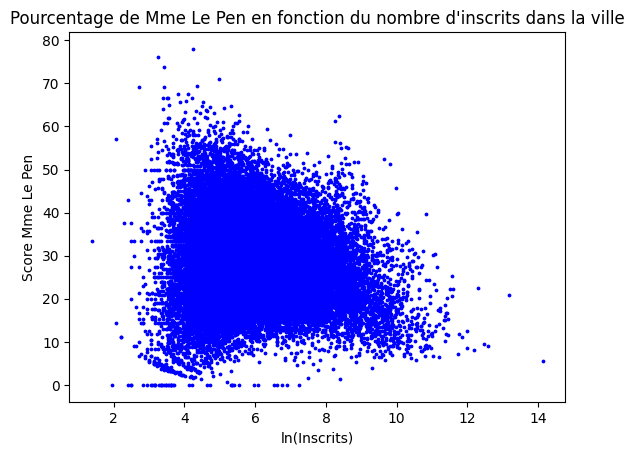

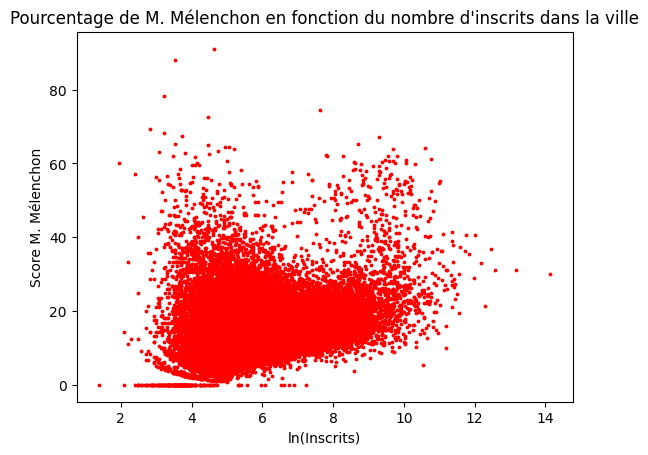

In [37]:
df_elect.plot.scatter(
    x="ln_Inscrits", 
        # on utilise le logarithme pour éviter que tous les points soient agglutinés sur l'axe des ordonnées
    y="score_rn",
    color="blue",
    s=3,
    alpha=1
)

plt.title("Pourcentage de Mme Le Pen en fonction du nombre d'inscrits dans la ville")
plt.xlabel("ln(Inscrits)")
plt.ylabel("Score Mme Le Pen")
plt.show()

df_elect.plot.scatter(
    x="ln_Inscrits", 
        # on utilise le logarithme pour éviter que tous les points soient agglutinés sur l'axe des ordonnées
    y="score_lfi",
    color="red",
    s=3,
    alpha=1
)

plt.title("Pourcentage de M. Mélenchon en fonction du nombre d'inscrits dans la ville")
plt.xlabel("ln(Inscrits)")
plt.ylabel("Score M. Mélenchon")
plt.show()


2. **Cartes de la France**

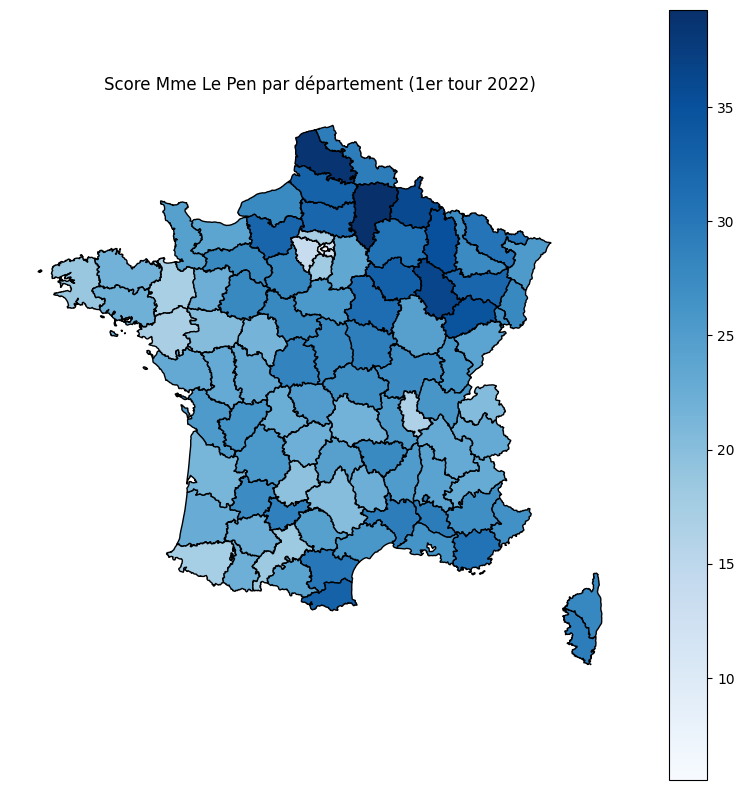

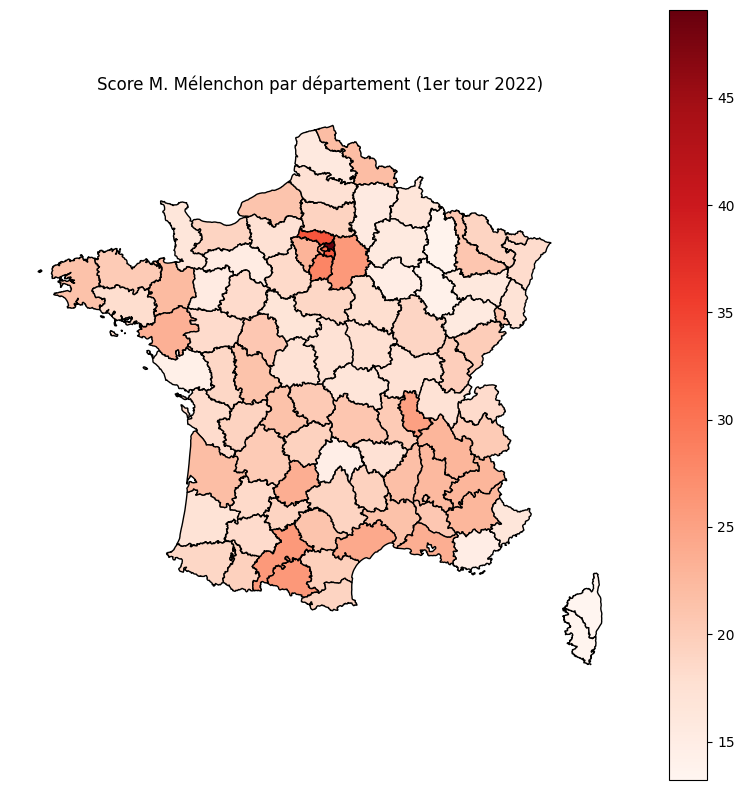

In [35]:
# Chargement du fond de carte départements

gdf_dep = gpd.read_file(
    "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
)

gdf_dep['code'] = gdf_dep['code'].astype(str).str.zfill(2)

# Fusion de la carte avec les données

carte_dep = gdf_dep.merge(
    df_departement,
    left_on='code',
    right_on='Code du département',
    how='left'
)

# Carte RN par département

fig, ax = plt.subplots(figsize=(10, 10))

carte_dep.plot(
    column='score_dep_rn',
    cmap='Blues',
    legend=True,
    edgecolor='black',
    ax=ax
)

ax.set_title("Score Mme Le Pen par département (1er tour 2022)")
ax.axis('off')
plt.show()

# Carte LFI par département

fig, ax = plt.subplots(figsize=(10, 10))

carte_dep.plot(
    column='score_dep_lfi',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax
)

ax.set_title("Score M. Mélenchon par département (1er tour 2022)")
ax.axis('off')
plt.show()


Les cartes suivantes sont cohérentes avec les statistiques publiées à propos des élections. Nous remarquons que Mme Le Pen a eu du succès dans les départements historiquement associés à l'industrie et à l'extraction de charbon (mines). Concernant M. Mélenchon, le département dans lequel il a eu le plus de succès est la Seine-Saint-Denis, ancienne banlieue rouge. A priori, ces résultats vont dans le sens de la documentation que nous avons consultée.

## b. Infrastructures sportives et culturelles

Dans un premier temps, on veut comprendre un peu mieux le jeu de données. Pour cela, on représente la répartition des infrastructures sur le territoire (infrastructures sportives, de loisirs, culturelles et l'ensemble) afin de mieux les visualiser. 

On crée d'abord une colonne qui somme les équipements présents dans une commune pour ensuite représenter cette somme sur l'ensemble du territoire, par commune. 

### i. Infrastructures sportives

In [81]:
df_com_sport["SUM_FACILITIES"] = df_com_sport.iloc[:, 1:].sum(axis=1)

df_com_sport.head()

,GEO,F101,F102,F103,F105,F106,F107,F108,F109,F110,...,F122,F123,F124,F125,F126,F127,F128,F129,F130,SUM_FACILITIES
0,01001,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,01004,3,8,10,0,3,7,0,2,0,...,2,0,0,0,0,0,0,10,2,85
2,01005,0,7,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,2,22
3,01007,0,5,4,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,23
4,01008,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11


Maintenant, on veut joindre les deux dataframes pour avoir à la fois la commune, le nombre d'équipements sportifs et la carte de la commune dans chaque ligne. Comme le géo-dataframe gdf_com a toutes les communes, contrairement à df_com_sport, on fait un LEFT JOIN de gdf_com vers df_com_sport (c'est à dire qu'on garde toutes les lignes de gdf_com et on met 0 si l'information n'est pas présente dans df_com_sport). 

In [82]:
gdf_map_sport = gdf_com.merge(
    df_com_sport[["GEO", "SUM_FACILITIES"]],
    left_on="INSEE_COM",
    right_on="GEO",
    how="left"
)

gdf_map_sport.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,100.0
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,28.0
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",38250,11.0


L'extrait de 5 communes est ici plutôt intéressant car on voit que des communes comme Connangles et Vidouze, 137 et 243 habitants n'ont pas d'informations sur leurs équipements, tandis que Fouesnant, Plougrescant et Montcarra (9864, 1166 et 569 habitants respectivement) en ont, et proportionnellement au nombre d'habitants (100, 28 et 11 respectivement). Cela semble plutôt cohérent, plus une commune a d'habitants, plus elle a des moyens et des besoins, plus elle va investir dans des infrastructures. 

On peut toutefois s'intéresser à l'étendue des valeurs et leur médiane. Il est très probable que quelques villes aient beaucoup d'infrastructures tandis que beaucoup en ont peu. Dans ce cas, il vaudra mieux tracer la carte avec une échelle logarithmique. 

In [83]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES"].max())

Le minimum d'infrastructure dans une commune est :  1.0
La médiane d'infrastructure dans une commune est :  8.0
Le maximum d'infrastructure dans une commune est :  4505.0


La répartition du nombre d'infrastructures dans les communes est très déséquilibrée, comme décrit plus haut, donc on ajoute une colonne SUM_FACILITIES_LOG = LOG(SUM_FACILITIES). 

> **Remarque** : On aurait pû choisir de faire LOG(1+SUM_FACILITIES) si jamais SUM_FACILITIES pouvait prendre la valeur 0, mais on a vu plus haut que le minimum était 1 donc ce n'est pas nécessaire. 

In [84]:
gdf_map_sport["SUM_FACILITIES_LOG"] = np.log1p(gdf_map_sport["SUM_FACILITIES"])

gdf_map_sport.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,100.0,4.615121
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,28.0,3.367296
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",38250,11.0,2.484907


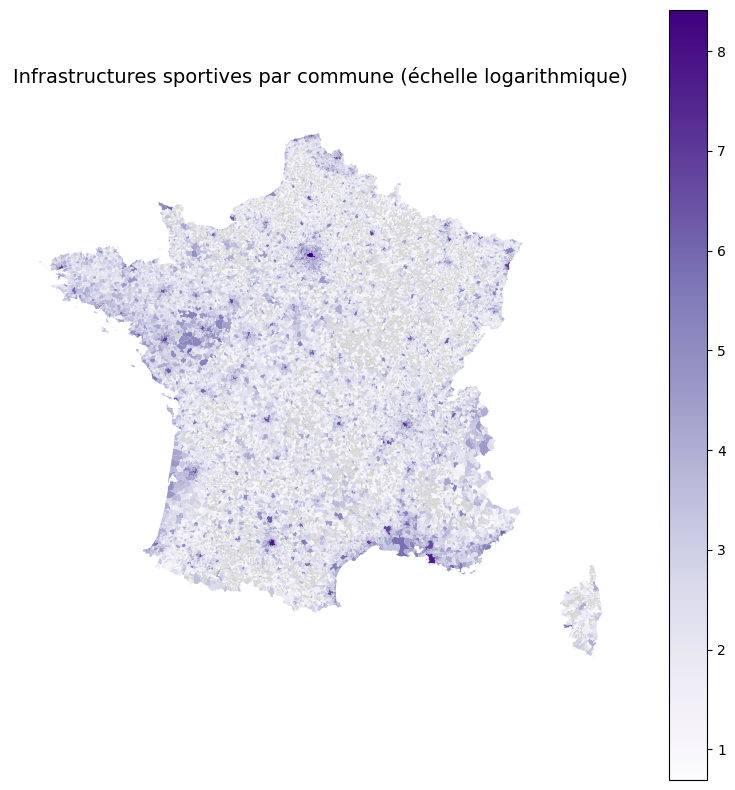

In [85]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_sport.plot(
    column="SUM_FACILITIES_LOG",
    ax=ax,
    cmap="Purples",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures sportives par commune (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

On peut également s'intéresser au nombre d'infrastructures sportives pour 1000 habitants. 

In [86]:
gdf_map_sport["SUM_FACILITIES_PER1000"] = gdf_map_sport["SUM_FACILITIES"]*1000/gdf_map_sport["POPULATION"]

gdf_map_sport.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,100.0,4.615121,10.137875
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,28.0,3.367296,24.013722
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",38250,11.0,2.484907,19.332162


In [87]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES_PER1000"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES_PER1000"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_sport["SUM_FACILITIES_PER1000"].max())

Le minimum d'infrastructure dans une commune est :  0.625
La médiane d'infrastructure dans une commune est :  10.395010395010395
Le maximum d'infrastructure dans une commune est :  1000.0


On a encore des données réparties essentiellement vers la droite, donc c'est on refait une colonne en échelle logarithmique. 

In [88]:
gdf_map_sport["SUM_FACILITIES_PER1000_LOG"] = np.log1p(gdf_map_sport["SUM_FACILITIES_PER1000"])

gdf_map_sport.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000,SUM_FACILITIES_PER1000_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,100.0,4.615121,10.137875,2.410351
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,28.0,3.367296,24.013722,3.219425
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",38250,11.0,2.484907,19.332162,3.012204


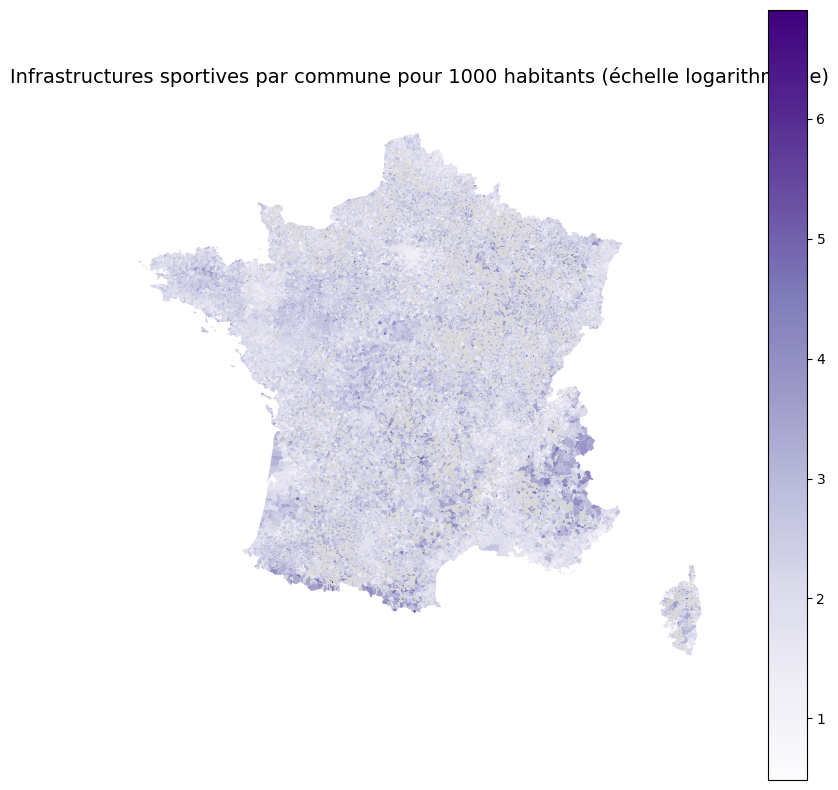

In [89]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_sport.plot(
    column="SUM_FACILITIES_PER1000_LOG",
    ax=ax,
    cmap="Purples",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures sportives par commune pour 1000 habitants (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

<span style='color:red'> **COMPLETER, FAIRE UN COMMENTAIRE** </span>

### ii. Infrastructures de loisirs

On réitère le travail fait dans la partie précédente mais cette fois avec les infrastructures de loisirs. L'objectif est donc de représenter le nombre d'équipements par commune pour commencer, et rapporté à 1000 habitants pour la suite. 

In [90]:
df_com_loisirs["SUM_FACILITIES"] = df_com_loisirs.iloc[:, 1:].sum(axis=1)

df_com_loisirs.head()

,GEO,F201,F202,F203,F204,SUM_FACILITIES
0,01001,0,0,2,0,2
1,01002,0,0,0,2,2
2,01004,0,0,2,5,7
3,01006,0,0,0,2,2
4,01007,0,0,2,2,4


In [91]:
gdf_map_loisirs = gdf_com.merge(
    df_com_loisirs[["GEO", "SUM_FACILITIES"]],
    left_on="INSEE_COM",
    right_on="GEO",
    how="left"
)

gdf_map_loisirs.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,45.0
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,13.0
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN


In [92]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES"].max())

Le minimum d'infrastructure dans une commune est :  1.0
La médiane d'infrastructure dans une commune est :  3.0
Le maximum d'infrastructure dans une commune est :  212.0


In [93]:
gdf_map_loisirs["SUM_FACILITIES_LOG"] = np.log1p(gdf_map_loisirs["SUM_FACILITIES"])

gdf_map_loisirs.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,45.0,3.828641
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,13.0,2.639057
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN


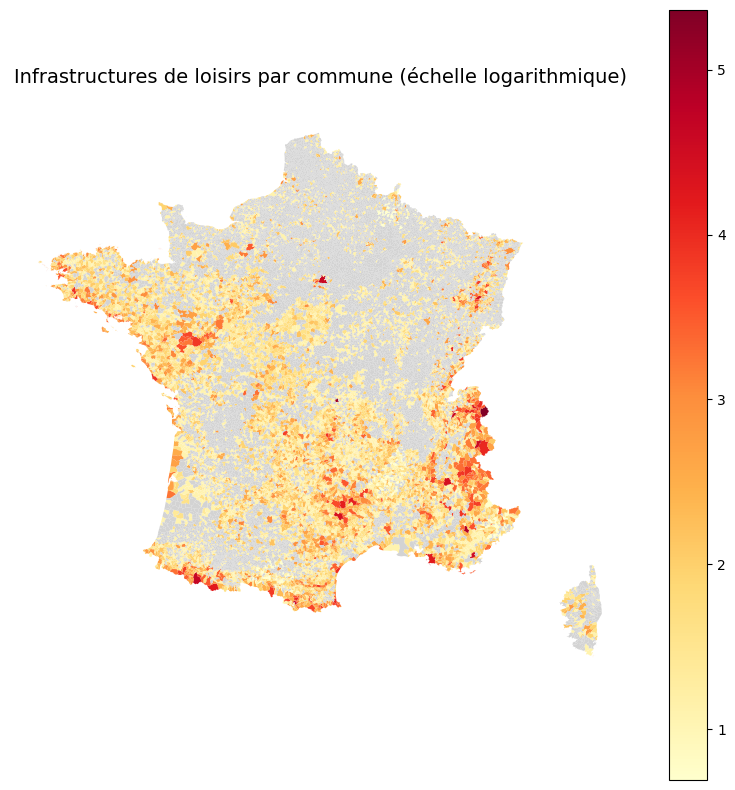

In [94]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_loisirs.plot(
    column="SUM_FACILITIES_LOG",
    ax=ax,
    cmap="YlOrRd",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures de loisirs par commune (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

In [95]:
gdf_map_loisirs["SUM_FACILITIES_PER1000"] = gdf_map_loisirs["SUM_FACILITIES"]*1000/gdf_map_loisirs["POPULATION"]

gdf_map_loisirs.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,45.0,3.828641,4.562044
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,13.0,2.639057,11.149228
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN,NaN


In [96]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES_PER1000"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES_PER1000"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_loisirs["SUM_FACILITIES_PER1000"].max())

Le minimum d'infrastructure dans une commune est :  0.0038243184586466885
La médiane d'infrastructure dans une commune est :  5.221932114882507
Le maximum d'infrastructure dans une commune est :  2000.0


In [97]:
gdf_map_loisirs["SUM_FACILITIES_PER1000_LOG"] = np.log1p(gdf_map_loisirs["SUM_FACILITIES_PER1000"])

gdf_map_loisirs.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000,SUM_FACILITIES_PER1000_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,45.0,3.828641,4.562044,1.715966
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,13.0,2.639057,11.149228,2.497266
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN,NaN,NaN


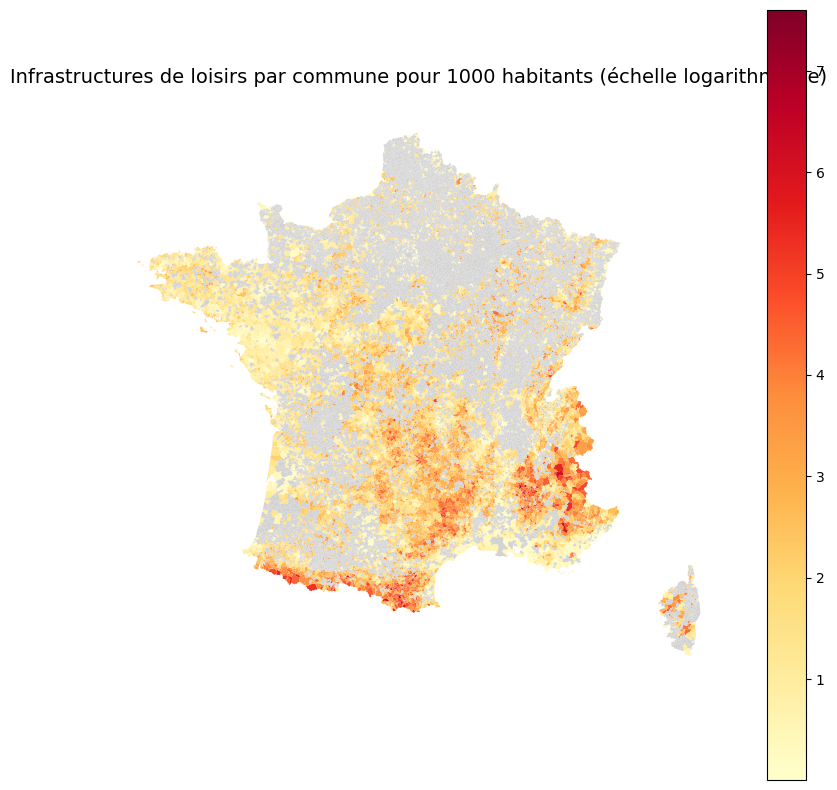

In [98]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_loisirs.plot(
    column="SUM_FACILITIES_PER1000_LOG",
    ax=ax,
    cmap="YlOrRd",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures de loisirs par commune pour 1000 habitants (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

### iii. Infrastructures culturelles

On réitère le travail fait dans la partie précédente mais cette fois avec les infrastructures culturelles. L'objectif est donc de représenter le nombre d'équipements par commune pour commencer, et rapporté à 1000 habitants pour la suite. 

In [99]:
df_com_culture["SUM_FACILITIES"] = df_com_culture.iloc[:, 1:].sum(axis=1)

df_com_culture.head()

,GEO,F303,F305,F307,F312,F313,F314,F315,SUM_FACILITIES
0,01004,1,0,1,0,0,1,0,3
1,01005,0,0,1,0,0,0,0,1
2,01007,0,0,1,1,0,0,0,2
3,01008,0,0,1,0,0,0,0,1
4,01010,0,0,1,0,0,0,0,1


In [100]:
gdf_map_culture = gdf_com.merge(
    df_com_culture[["GEO", "SUM_FACILITIES"]],
    left_on="INSEE_COM",
    right_on="GEO",
    how="left"
)

gdf_map_culture.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,1.0
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,1.0
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN


In [101]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES"].max())

Le minimum d'infrastructure dans une commune est :  1.0
La médiane d'infrastructure dans une commune est :  1.0
Le maximum d'infrastructure dans une commune est :  524.0


In [102]:
gdf_map_culture["SUM_FACILITIES_LOG"] = np.log1p(gdf_map_culture["SUM_FACILITIES"])

gdf_map_culture.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,1.0,0.693147
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,1.0,0.693147
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN


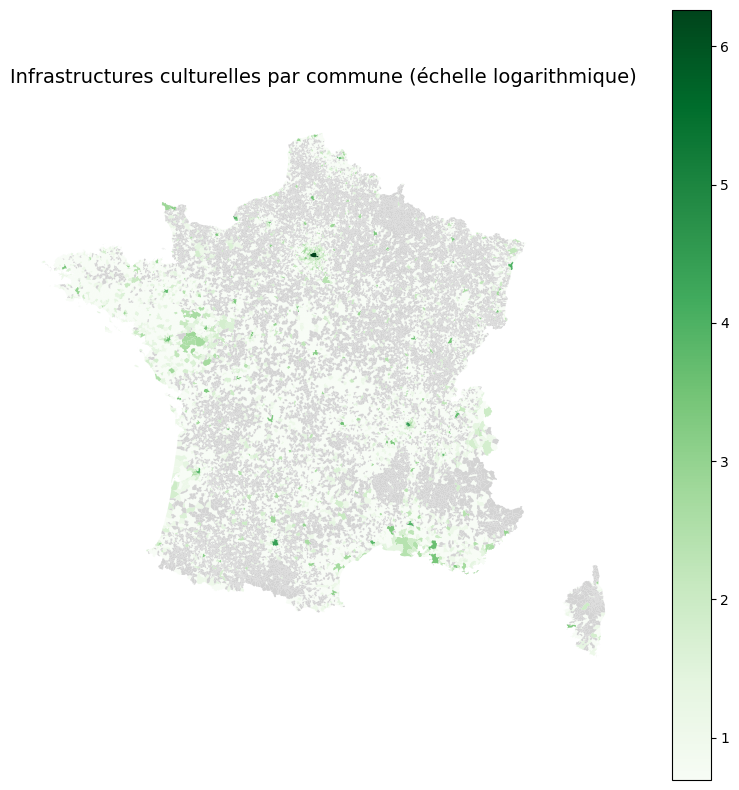

In [103]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_culture.plot(
    column="SUM_FACILITIES_LOG",
    ax=ax,
    cmap="Greens",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures culturelles par commune (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

In [104]:
gdf_map_culture["SUM_FACILITIES_PER1000"] = gdf_map_culture["SUM_FACILITIES"]*1000/gdf_map_culture["POPULATION"]

gdf_map_culture.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,1.0,0.693147,0.101379
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,1.0,0.693147,0.857633
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN,NaN


In [105]:
print("Le minimum d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES_PER1000"].min())
print("La médiane d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES_PER1000"].median())
print("Le maximum d'infrastructure dans une commune est : ", gdf_map_culture["SUM_FACILITIES_PER1000"].max())

Le minimum d'infrastructure dans une commune est :  0.02723385713118549
La médiane d'infrastructure dans une commune est :  0.9049773755656109
Le maximum d'infrastructure dans une commune est :  76.92307692307692


In [106]:
gdf_map_culture["SUM_FACILITIES_PER1000_LOG"] = np.log1p(gdf_map_culture["SUM_FACILITIES_PER1000"])

gdf_map_culture.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry,GEO,SUM_FACILITIES,SUM_FACILITIES_LOG,SUM_FACILITIES_PER1000,SUM_FACILITIES_PER1000_LOG
0,COMMUNE_0000000009754033,Connangles,CONNANGLES,43076,Commune simple,137,11,1,43,84,200073419,"POLYGON ((748166.1 6463826.6, 748132.4 6463873...",NaN,NaN,NaN,NaN,NaN
1,COMMUNE_0000000009760784,Vidouze,VIDOUZE,65462,Commune simple,243,13,3,65,76,200072106,"POLYGON ((455022.6 6263681.9, 455008 6263694.5...",NaN,NaN,NaN,NaN,NaN
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((177277.8 6756845.8, 177275.5 6...",29058,1.0,0.693147,0.101379,0.096563
3,COMMUNE_0000000009735245,Plougrescant,PLOUGRESCANT,22218,Commune simple,1166,27,3,22,53,200065928,"MULTIPOLYGON (((245287.3 6878865.1, 245288.4 6...",22218,1.0,0.693147,0.857633,0.619303
4,COMMUNE_0000000009752504,Montcarra,MONTCARRA,38250,Commune simple,569,24,2,38,84,200068542,"POLYGON ((889525.8 6504614.5, 889525.6 6504597...",NaN,NaN,NaN,NaN,NaN


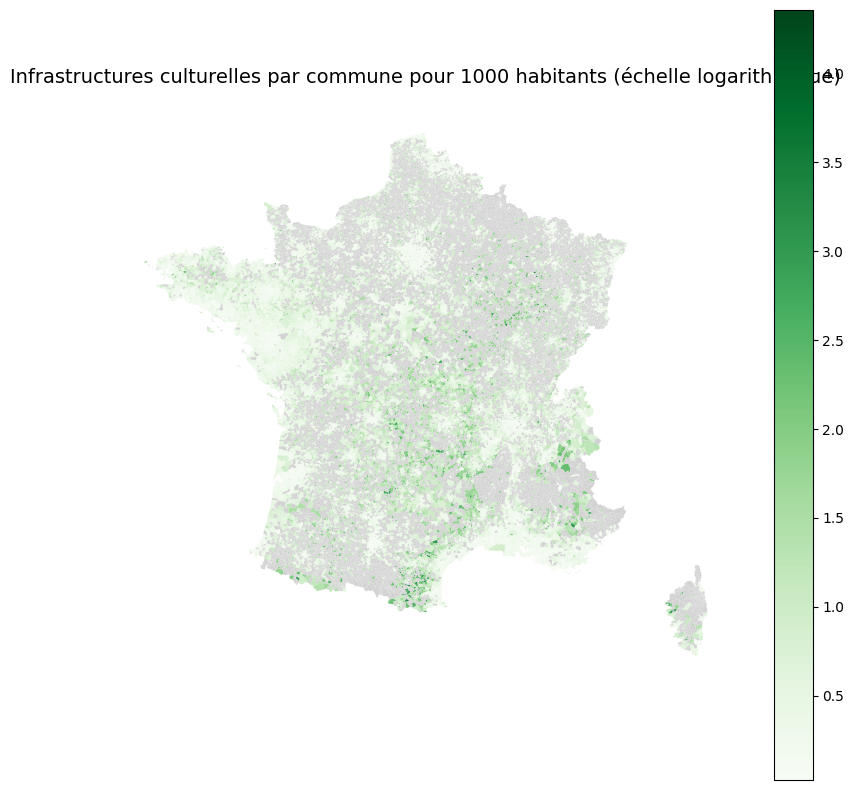

In [107]:
#créer la figure où la carte sera tracée
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#tracer la carte
gdf_map_culture.plot(
    column="SUM_FACILITIES_PER1000_LOG",
    ax=ax,
    cmap="Greens",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée non disponible"
    }
)

#titres de la figure 
ax.set_title("Infrastructures culturelles par commune pour 1000 habitants (échelle logarithmique)", fontsize=14)
ax.axis("off")

#montrer la figure
plt.show()

# Machine Learning

Une partie machine learning avec le type de modèle utilisé et ce dans le but de confirmer quelle hypothèse? Est-ce que vos données se prêtent bien au modèle que vous utilisez? Est-ce que vous avez fait un prétraitement (centrer réduit par exemple, variables catégories etc…)

# Conclusion

Une partie conclusion où vous rappelez vos résultats principaux mais aussi développez les limites de votre étude : Est-ce que vous pensez avoir complètement répondu à la question? Est-ce que vous avez identifié des angles morts? Comment est-ce que vous feriez pour les corriger etc…